In [5]:
# data loading and setting up file directories
%cd /home/jovyan/work/solar-pv

/home/jovyan/work/solar-pv


In [57]:
!rm -rf ~/work/solar-pv/data/
!cp -R ~/work/solar-pv/data_bkp/ ~/work/solar-pv/data/

In [30]:
!rm -rf ./data/training/.ipynb_checkpoints/

In [1]:
#import the libraries
import shutil
import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import sklearn.metrics as metrics
from skimage.feature import hog
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
warnings.filterwarnings('ignore')

In [2]:
#path for training and labels file
dir_train_images  = './data/'
dir_train_labels  = './data/labels_training.csv'

In [3]:
def load_labels(dir_labels):
    labels = dict()
    cnt = 0
    
    with open (dir_labels) as f:
        for i in f:
            # skip first row of text name
            cnt += 1 
            if cnt == 1:
                continue
            # create dictionary with key-value pair of image_id-image_label
            i = i.split(',')
            labels[int(i[0])] = int(i[1][0])

    return labels

In [4]:
# load image labels
labels = load_labels(dir_train_labels)

In [5]:
#Split the data in 80-20 percent ratio for training and validation 
def split_train_val(labels):
    val_dic = {}
    np.random.seed(100)
    val_idx = np.random.randint(0, 1500, 300)
    
    # for validation set
    # create dictionary with key-value pair of img_id-img_label
    for idx in val_idx:
        val_dic[idx] = labels[idx] 
        
    return val_dic

In [8]:
'''
Loaded data as per Pytorch specification for DataLoader for training and validation
Two directories for positive (is_true) and negative (is_false) classification are created 
'''

def load_data(path, vals_dics, labels):
    # initialize paths
    trainig_path = path + 'training/'
    validation_path = path + 'validation/'
    files = os.listdir(trainig_path)
    f1 = path
    t_folder, f_folder = 'is_true/', 'is_false/'
    
    # if not exist such folder 
    # create the required folder and subfolders
    if not os.path.exists(f1):
        os.makedirs(f1)

    if not os.path.exists(f1 + 'training/'):
        os.makedirs(f1 + 'training/')
    
    if not os.path.exists(f1 + 'training/' + t_folder):
        os.makedirs(f1 + 'training/' + t_folder)

    if not os.path.exists(f1 + 'training/' + f_folder):
        os.makedirs(f1 + 'training/' + f_folder)
        
    if not os.path.exists(f1 + 'validation/'):
        os.makedirs(f1 + 'validation/')
        
    if not os.path.exists(f1 + 'validation/' + t_folder):
        os.makedirs(f1 + 'validation/' + t_folder)

    if not os.path.exists(f1 + 'validation/' + f_folder):
        os.makedirs(f1 + 'validation/' + f_folder)
    
    for i in range(len(files)):
        fi = files[i]
        idx = int(fi[:-4])
        
        move_path = trainig_path
        # if file belongs to validation set
        # move it from training to validation folder
        # otherwise stay in training folder
        if idx in vals_dics.keys():
            move_path = validation_path
        
        # create subfolders representing classes for dataloader
        li = labels[idx]
        # if labeled 1, move file to is_true folder
        if li == 1:
            shutil.move(trainig_path + fi , move_path + t_folder + fi)
            print(trainig_path + fi , move_path + t_folder + fi)
        
        # if labeled 0, move file to is_false folder
        elif li == 0:
            shutil.move(trainig_path + fi , move_path + f_folder + fi)
            print (trainig_path + fi , move_path + f_folder + fi)
        else:
            exit(-1)

In [73]:
#housekeeping for rerunning the DataLoader
!rm -rf ~/work/solar-pv/data/
!cp -R ~/work/solar-pv/data_bkp/ ~/work/solar-pv/data/

load_data(dir_train_images, vals_dics, labels)

files 1500
./data/training/1127.tif ./data/training/is_true/1127.tif
./data/training/1128.tif ./data/training/is_true/1128.tif
./data/training/1129.tif ./data/training/is_false/1129.tif
Path is VALIDATION
./data/training/113.tif ./data/validation/is_true/113.tif
./data/training/1130.tif ./data/training/is_false/1130.tif
./data/training/1131.tif ./data/training/is_false/1131.tif
./data/training/1132.tif ./data/training/is_false/1132.tif
./data/training/1133.tif ./data/training/is_false/1133.tif
./data/training/1134.tif ./data/training/is_false/1134.tif
./data/training/1135.tif ./data/training/is_false/1135.tif
./data/training/1136.tif ./data/training/is_true/1136.tif
./data/training/1137.tif ./data/training/is_true/1137.tif
./data/training/1074.tif ./data/training/is_true/1074.tif
./data/training/1075.tif ./data/training/is_true/1075.tif
Path is VALIDATION
./data/training/1076.tif ./data/validation/is_false/1076.tif
Path is VALIDATION
./data/training/1077.tif ./data/validation/is_false/

In [9]:
# data augmentation dictionary with chained transformations
data_transforms = {
'train': transforms.Compose([
    #Randomly scaled to 224 x 224 pixels
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #Normalized using Mean and Standard Deviation of RGB pixels of ImageNet dataset 
    #This value is used by Pytorch library and has proven to provide decent performance
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    #Enlarge the image to 256by256 and later crop in the center
    transforms.Scale(256),
    #Centered cropped to 224 x 224 pixels to have similar size as ImageNet dataset
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #Normalized using Mean and Standard Deviation of RGB pixels of ImageNet dataset 
    #This value is used by Pytorch library and has proven to provide decent performance
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [10]:
# loading data using pytorch dataloader
data_dir = './data/'
image_datasets = datasets.ImageFolder(data_dir + 'training/', data_transforms['train'])
val_datasets = datasets.ImageFolder(data_dir + 'validation/', data_transforms['val'])

dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=30, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(val_datasets, batch_size=30, shuffle=False, num_workers=4)

In [11]:
#ResNet-18 pretrained model
def model():
    #return models.VGG18(pretrained=True)
    return models.resnet18(pretrained=True)

#Stochastic Gradient Descent
def get_optimizer(model_ft):
    #return optim.Adam(model_ft.parameters(), lr=0.01)
    return optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

In [12]:
#Training and Validation step
def fit(num_epoch=20):

    #get model
    model_ft = model()
    num_ftrs = model_ft.fc.in_features
    #Fully connected layers for positive and negative classification
    model_ft.fc = nn.Linear(num_ftrs, 2)

    model_ft = model_ft.cuda()
    #Loss Function
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model_ft)

    y_preds = []
    y_label = []
        
    for epoch in range(num_epoch):
        pred_l = []
        y_l = []
        #Training Step
        for data in dataloader:
            # model fitting
            model_ft.train()
            x, y = data
            x = Variable(x).cuda()
            y = Variable(y).cuda()
            pred = model_ft(x)
 
            loss = criterion(pred, y) # define cost function
            optimizer.zero_grad() # initialize weights to 0 for each sample
            loss.backward() # backwardpropogation
            optimizer.step() # adjust weights accordingly

            pred_l.append(pred[:, -1].data.cpu().numpy())
            y_l.append(y.data.cpu().numpy() )

        # flatten to 1D array
        pred_l = np.concatenate(pred_l) 
        y_l = np.concatenate(y_l)
        print (epoch, 'train', round(metrics.roc_auc_score(y_l, pred_l), 2))
        
        # for validation set
        pred_l = []
        y_l = []
        pred_result_l = []

        for data in valloader:
            model_ft.eval()
            x, y = data
            x = Variable(x).cuda()
            y = Variable(y).cuda()
            pred = model_ft(x) #Predict the outcomes
            _, pred_result = torch.max(pred, 1) # store binary prediction results
            
            pred_result_l.append(pred_result.data.cpu().numpy())
            pred_l.append(pred[:, -1].data.cpu().numpy())
            y_l.append(y.data.cpu().numpy())

        # flatten to 1D array
        pred_l = np.concatenate(pred_l)
        y_l = np.concatenate(y_l)
        pred_result_l = np.concatenate(pred_result_l)
        
        y_preds = pred_l
        y_label = y_l
        y_pred_result = pred_result_l
        
        print (epoch, 'val', round(metrics.roc_auc_score(y_l, pred_l), 2))
    
    print('Fnished Epochs')
    return y_preds, y_label, y_pred_result

In [13]:
#Run the training and validation for 20 epochs
y_preds, y_label, y_pred_result = fit(20)

0 train 0.8
0 val 0.87
1 train 0.92
1 val 0.98
2 train 0.94
2 val 0.98
3 train 0.95
3 val 0.96
4 train 0.94
4 val 0.97
5 train 0.98
5 val 0.99
6 train 0.96
6 val 0.99
7 train 0.97
7 val 0.98
8 train 0.97
8 val 0.97
9 train 0.97
9 val 0.99
10 train 0.97
10 val 0.97
11 train 0.98
11 val 0.99
12 train 0.99
12 val 0.99
13 train 0.98
13 val 0.98
14 train 0.98
14 val 0.99
15 train 0.99
15 val 0.98
16 train 0.99
16 val 0.99
17 train 0.98
17 val 0.99
18 train 0.99
18 val 0.99
19 train 0.99
19 val 0.99
Fnished Epochs


### Find Misclassified Images

In [49]:
df = pd.DataFrame()
df['y_label'] = list(y_label)
df['y_preds'] = list(y_preds)
#df.to_csv('./output.csv')

In [58]:
df = pd.DataFrame()
df['y_label'] = list(y_label)
df['y_pred_result'] = list(y_pred_result)

preds_siged = 1/(1+np.exp(-y_preds))
df['y_preds_siged'] = list(preds_siged)
#df.to_csv('./output2.csv')

In [38]:
df[df.y_label!=df.y_pred_result]

,y_label,y_pred_result,y_preds_siged
171,0,1,0.878244
216,1,0,0.369837
230,1,0,0.077340
256,1,0,0.225519
257,1,0,0.115549


In [20]:
df.y_label.value_counts()

0    208
1     92
Name: y_label, dtype: int64

In [21]:
y_pred_result[:208] # reading data/validation/is_false folder first

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
y_pred_result[208:] # reading data/validation/is_true folder first

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [31]:
# false negative index
idx_is_true = []
for i in range(209, 300):
    if y_pred_result[i] == 0:
        idx_is_true.append(i)  
idx_is_true

[216, 230, 256, 257]

In [23]:
# false positive index
idx_is_false = []
for i in range(208):
    if y_pred_result[i] == 1:
        idx_is_false.append(i)   
idx_is_false

[171]

In [40]:
## Find corresponding file name and prediction score
# Within data/validation/is_true folder
files_val_t = os.listdir('./data/validation/is_true')
print ('len(files_val_t)=', len(files_val_t))

file_is_true = []
for i in range(len(files_val_t)):
    if (i+208) in idx_is_true:
        fi = files_val_t[i]
        file_is_true.append(fi)
        print('is_true:',fi, 'predicted_score:', preds_siged[i+208])

len(files_val_t)= 92
is_true: 1234.tif predicted_score: 0.36983678
is_true: 1380.tif predicted_score: 0.07734009
is_true: 383.tif predicted_score: 0.22551899
is_true: 385.tif predicted_score: 0.115549155


In [41]:
# Within data/validation/is_false folder
files_val_f = os.listdir('./data/validation/is_false')
print ('len(files_val_f)=', len(files_val_f))

file_is_false = []
for i in range(len(files_val_f)):
    if (i in idx_is_false):
        fi = files_val_f[i]
        file_is_false.append(fi)
        print('is_false:',fi,'predicted_score:', preds_siged[i])

len(files_val_f)= 208
is_false: 802.tif predicted_score: 0.87824416


In [91]:
fname_0 = ['177.tif','218.tif','548.tif','882.tif']
fname_1 = ['4.tif', '146.tif', '148.tif','1415.tif']

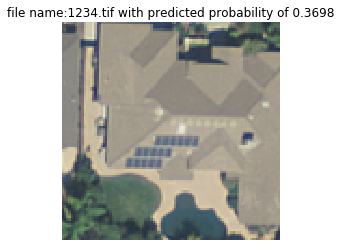

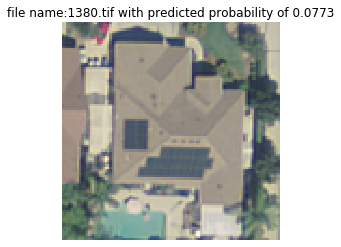

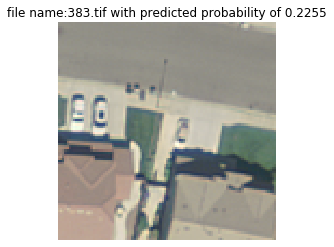

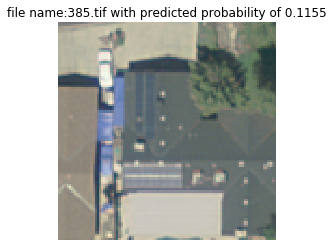

In [73]:
## Misclassified images
# Four false negatives
for i in range(len(file_is_true)):
    image = mpl.image.imread('./data/validation/is_true/'+file_is_true[i])
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'file name:{file_is_true[i]} with predicted probability of {preds_siged[idx_is_true[i]]:.4f}', 
                 fontsize=12)
    plt.show()

802.tif


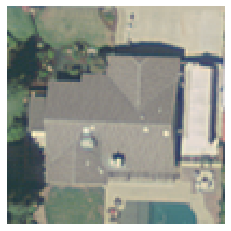

In [27]:
# One false positive
import matplotlib as mpl
for fname in file_is_false:
    print(fname)
    image = mpl.image.imread('./data/validation/is_false/'+fname)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Assessment with ROC and PR curves

In [55]:
def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Random Guess')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.title('ROC curve')
    plt.tight_layout()

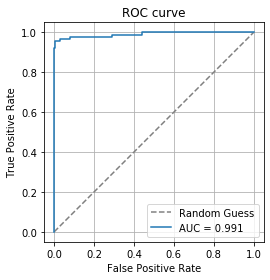

In [57]:
plot_roc(y_label, y_preds)

In [30]:
# saving results to npy
np.save('preds_siged',preds_siged)
np.save('y_preds', y_preds) #without sigmoid yet

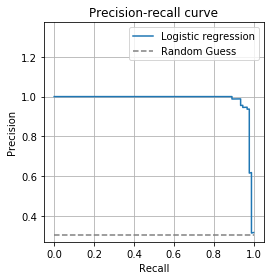

In [27]:
### model assessment
precision, recall, thres = precision_recall_curve(y_labels, y_preds, pos_label=1)
plt.plot(recall, precision, label='Logistic regression')

pos_prop = len(y_labels[y_labels == 1])/len(y_labels)
plt.plot([0,1],[pos_prop,pos_prop], '--', color = 'grey', label = 'Random Guess')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid('on')
plt.axis('square')
plt.legend()
plt.title('Precision-recall curve')
plt.tight_layout()